# Определение возраста покупателей

Импортируем полезные библиотеки, которые пригодятся нам в дальнейшем

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
from IPython.core.display import display, HTML
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

Объявим константы и зададим параметры по умолчанию, которые понадобятся нам в дальнейшем

In [2]:
RANDOM_STATE = 144210
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

display(HTML("<style>.container { width:75% !important; }</style>"))
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.rc('font', size=SMALL_SIZE)                                    # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)                              # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)                              # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)                              # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)                              # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)                              # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)                            # fontsize of the figure title
plt.rc('figure', figsize=(18, 6))                                  # size of the figure

## Исследовательский анализ данных

### Загрузка csv-файла:

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')

### Ознакомимся с набором данных:

In [4]:
labels.head(8)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43


### Отобразим информацию для краткого обзора данных:

In [5]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


### Отобразим таблицу с описательной статистикой столбцов:

In [6]:
labels.describe()

,real_age
count,7591.00
mean,31.20
std,17.15
min,1.00
25%,20.00
50%,29.00
75%,41.00
max,100.00


### Отобразим гистограммы распределений значений столбцов:

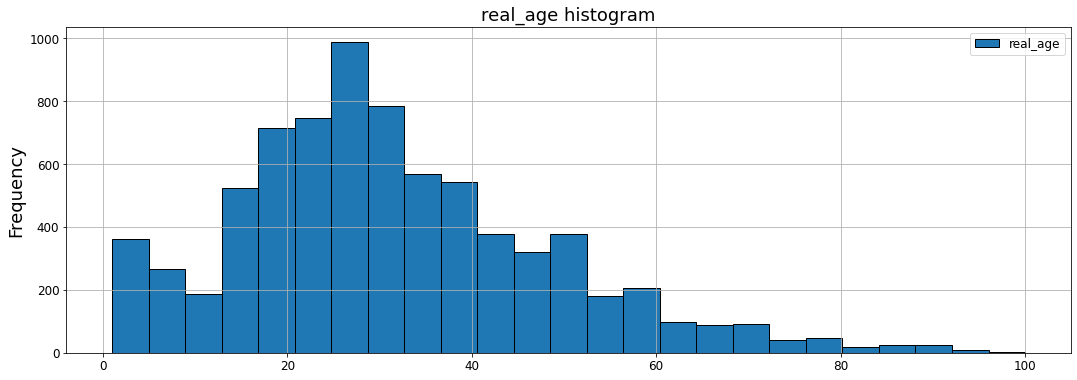

In [7]:
labels.plot(kind='hist', bins=25, edgecolor='black', grid=True, legend=True, title='real_age histogram', xlabel='age', ylabel='frequency');

### Создадим генератор изображений:

In [8]:
train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True)

validation_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255)

train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    subset='training',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

val_datagen_flow = validation_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    subset='validation',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345)

Found 5694 validated image filenames.
Found 1897 validated image filenames.


### Напечатаем на экран несколько фотографий:

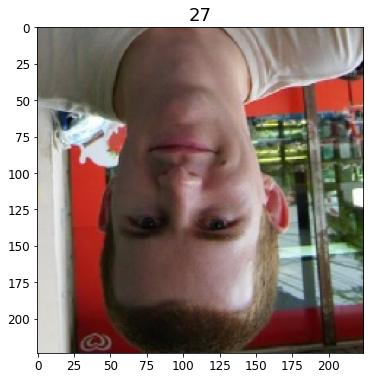

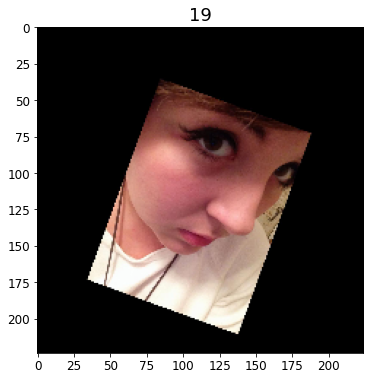

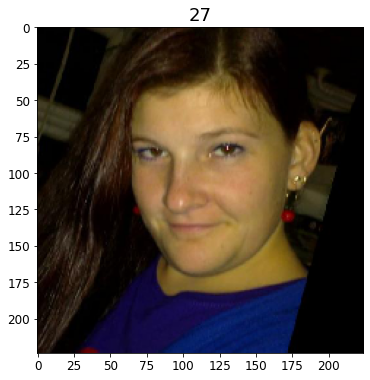

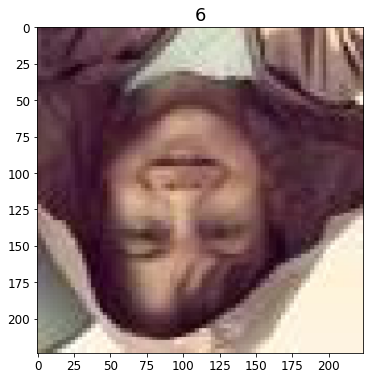

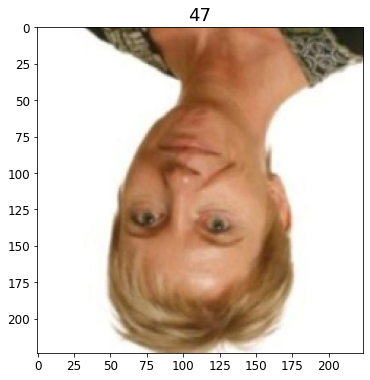

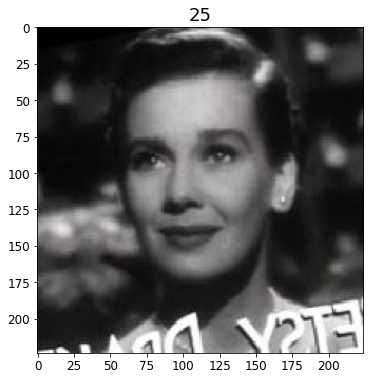

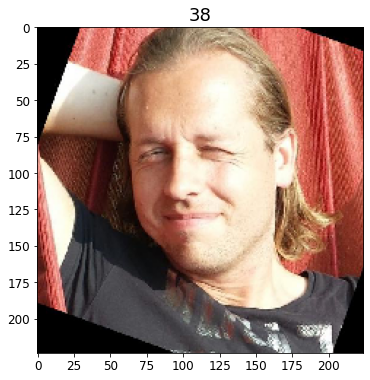

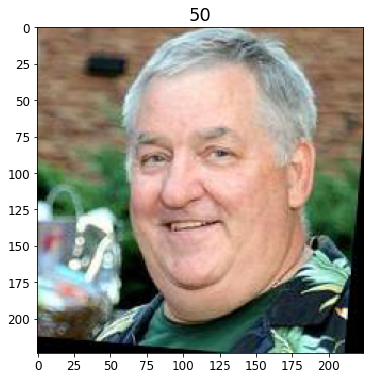

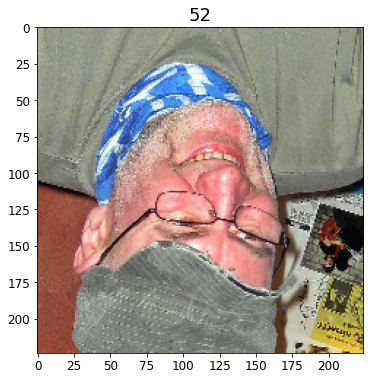

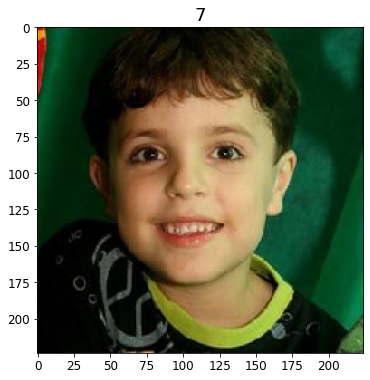

In [9]:
# Напечатаем фотографии на экран с копии генератора тренировочной выборки, чтобы не потерять часть данных
train_datagen_flow, train_datagen_flow_copy = itertools.tee(train_datagen_flow)

datagen_batch = next(train_datagen_flow_copy)
for image, age in zip(datagen_batch[0][:10], datagen_batch[1][:10]):
    plt.imshow(image)
    plt.title(age)
    plt.show()   

### Краткий вывод:
- половина людей имеют возраст до 29 лет, а другая половина от 29 лет
- в выборке присутствуют фотографии как младенцев, так и пожилых людей (от 1 до 100 лет)
- часть изображений обрезаны и немного повернуты

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
import numpy as np
import pandas as pd

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255., horizontal_flip=True, vertical_flip=True)
    labels = pd.read_csv(path+'labels.csv')
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        subset='training',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
 
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    labels = pd.read_csv(path+'labels.csv')

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col='file_name',
        y_col='real_age',
        subset='validation',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)
    
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['mae'])
    
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model
```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 70s - loss: 261.5565 - mae: 11.8660 - val_loss: 735.6202 - val_mae: 22.1901
Epoch 2/10
178/178 - 42s - loss: 104.9200 - mae: 7.7687 - val_loss: 868.6662 - val_mae: 24.5436
Epoch 3/10
178/178 - 40s - loss: 81.1088 - mae: 6.8286 - val_loss: 432.4492 - val_mae: 15.7851
Epoch 4/10
178/178 - 39s - loss: 61.8950 - mae: 6.0032 - val_loss: 181.4201 - val_mae: 10.7993
Epoch 5/10
178/178 - 39s - loss: 54.9790 - mae: 5.6186 - val_loss: 96.6027 - val_mae: 7.3369
Epoch 6/10
178/178 - 39s - loss: 43.5097 - mae: 5.0489 - val_loss: 86.5907 - val_mae: 6.9403
Epoch 7/10
178/178 - 39s - loss: 38.1508 - mae: 4.6814 - val_loss: 81.2628 - val_mae: 6.6760
Epoch 8/10
178/178 - 39s - loss: 35.6848 - mae: 4.5297 - val_loss: 76.7847 - val_mae: 6.7029
Epoch 9/10
178/178 - 39s - loss: 29.5287 - mae: 4.1845 - val_loss: 95.8673 - val_mae: 7.6241
Epoch 10/10
178/178 - 39s - loss: 27.4025 - mae: 3.9868 - val_loss: 74.7886 - val_mae: 6.4131
60/60 - 10s - loss: 74.7886 - mae: 6.4131
Test MAE: 6.4131
```

## Анализ обученной модели

- в качестве модели мы использовали `ResNet50` с одим полносвязным слоем
- аугментация данных сильно улучшила качество прогнозов модели
- модель успешно справилась с задачей, итоговое качество `MAE` на тестовой выборке равно $6.4131$
- модель можно успешно использовать для предсказания возраста по фото человека

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы